Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12eab8e50>
Traceback (most recent call last):
  File "/Users/shohei/.pyenv/versions/3.9.2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/shohei/.pyenv/versions/3.9.2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


(-0.5, 255.5, 255.5, -0.5)

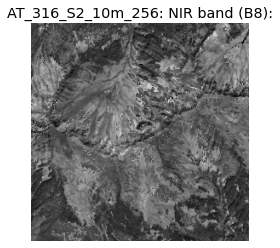

In [12]:
import numpy as np
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl

base_file = 'AT_316_S2_10m_256'
data = Dataset('../app/data/'+base_file+'.nc')
fp = '../app/data/'+base_file+'.tif'
img = rasterio.open(fp)
time_slice = 0 # 0 to 5
B2 = np.array(data['B2'][time_slice,:,:])
B3 = np.array(data['B3'][time_slice,:,:])
B4 = np.array(data['B4'][time_slice,:,:])
B8 = np.array(data['B8'][time_slice,:,:])
B2 = (255 * (B2 / B2.max() )).astype(np.int8)
B3 = (255 * (B3 / B3.max() )).astype(np.int8)
B4 = (255 * (B4 / B4.max() )).astype(np.int8)
B8 = (255 * (B8 / B8.max() )).astype(np.int8)

extent_img = img.read(1)
boundary_img = img.read(2)
distance_img = img.read(3)
extent_img = extent_img.astype(np.uint8)
boundary_img = boundary_img.astype(np.uint8)
distance_img = distance_img.astype(np.uint8)
    
test_input = np.zeros((3,256,256))
test_mask  = np.zeros((1,256,256))

test_input[0,:,:] = B3
test_input[1,:,:] = B4
test_input[2,:,:] = B8
test_mask[0,:,:] = boundary_img

test_dataset = [{'image': test_input.astype(np.uint8), 'mask': test_mask.astype(np.float32)}]
n_cpu = os.cpu_count()
BATCH_SIZE = 1
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)

plt.imshow(test_dataset[0]['image'][2,:,:],cmap='gray')
plt.title("{0}: NIR band (B8):".format(base_file))
plt.axis('off')

In [17]:
import segmentation_models_pytorch as smp

class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]
        assert image.ndim == 4
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0
        mask = batch["mask"]
        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= 0
        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)
        prob_mask = logits_mask.sigmoid()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [18]:
model_folder = '/Users/shohei/ghq/huggingface.co/shoheiaoki/delineation-satellite/'
model_path = model_folder+'model_500epochs.pth'
model = PetModel("Unet", "resnet34", in_channels=3, out_classes=1)
model.load_state_dict(torch.load(model_path))


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/shohei/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████████████████████████████████████████████████████| 83.3M/83.3M [00:13<00:00, 6.46MB/s]


<All keys matched successfully>

In [20]:
    print("1")
    it = iter(test_dataloader)
    print("2")
    batch = next(it)
    print("3")

1
2
3


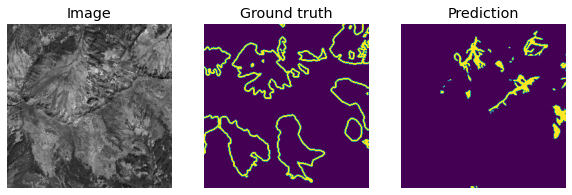

In [19]:
batch = next(iter(test_dataloader))

with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy()[2,:,:],cmap='gray')  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

